<a href="https://colab.research.google.com/github/Archi2903/AI-in-Engenery/blob/main/Project_CNN_in_EM_Russia_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Energy resources and artificial intelligence[202502-ENR4320-001]
22251844 이도윤

#Denoising TEM Data with CNN(feedback) Autoencoder
This project will be demonstrates how a Convolutian Network Autoencoder can effectively suppress complex noise types in Transient Electromagnetic (TEM) decay signals.
Synthetic data are generated to simulate realistic noisy conditions, and the model learns to reconstruct the underlying clean signal from these corrupted observations.

2. Data Generation

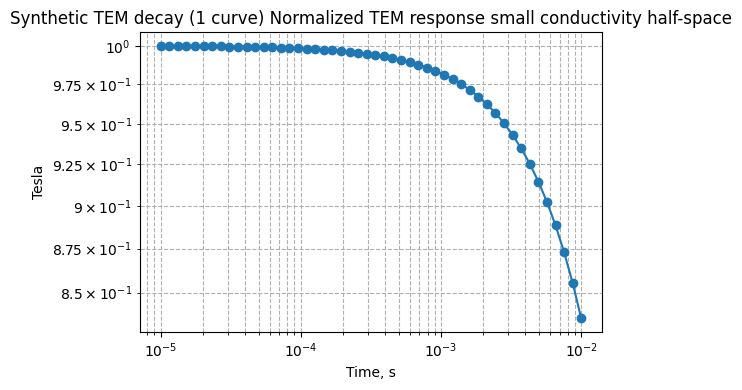

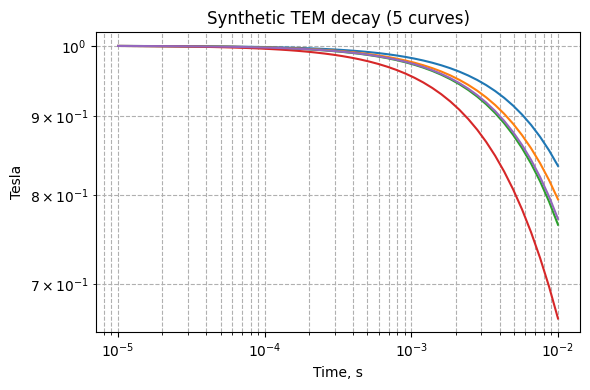

In [1]:
# Synthetic TEM Data Generation
# Synthetic data emulate realistic TEM decays using sums of exponential

import numpy as np
import matplotlib.pyplot as plt

# Example: generate one synthetic clean TEM decay signal (normalized)
def generate_clean_signal(n_points=50):
    t = np.logspace(-5, -2, n_points)  # time (s)
    y = np.zeros_like(t)

    # Sum of a few decaying exponentials(stacking)
    for A, tau in zip(np.random.uniform(0.5,1.5,3), np.random.uniform(0.01,0.1,3)):
        y += A * np.exp(-t/tau)
    y = y / np.max(y)  # normalize amplitude
    return t, y

# Generate dataset
n_samples = 200
times = []
clean_signals = []
for i in range(n_samples):
    t, y = generate_clean_signal()
    times.append(t)
    clean_signals.append(y)

# Plot example
# 1 curve from 200
t_plot = times[0]
y_plot = clean_signals[0]

plt.figure(figsize=(6, 4))
plt.loglog(t_plot, y_plot, marker='o')  # Log scale
plt.xlabel("Time, s")
plt.ylabel("Tesla")
plt.title("Synthetic TEM decay (1 curve) Normalized TEM response small conductivity half-space")
plt.grid(True, which="both", ls="--")
plt.tight_layout()


plt.figure(figsize=(6, 4))
for i in range(5):  # 5curve
    plt.loglog(times[i], clean_signals[i])
plt.xlabel("Time, s")
plt.ylabel("Tesla")
plt.title("Synthetic TEM decay (5 curves)")
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


Dataset shape: (200, 50, 1) (200, 50, 1)


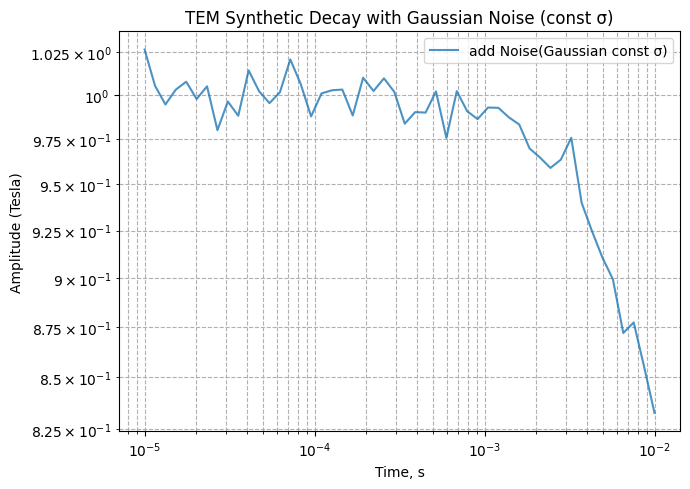

In [21]:
# add Gaussian noise in Clean signal (const variance)
def add_gaussian_const_noise(y):
    y = np.array(y)
    sigma_const = 0.01 * np.max(y)
    noisy = y + np.random.normal(0, sigma_const, size=y.shape)
    return noisy

# Make Dataset for training
X_noisy = []
Y_clean = []

for t, y in zip(times, clean_signals):
    noisy = add_gaussian_const_noise(y)
    X_noisy.append(noisy.reshape(-1, 1))
    Y_clean.append(y.reshape(-1, 1))

X_noisy = np.array(X_noisy)
Y_clean = np.array(Y_clean)

print("Dataset shape:", X_noisy.shape, Y_clean.shape)

# Plot
t_example = times[0]
y_example = clean_signals[0]
noisy_example = add_gaussian_const_noise(y_example)

plt.figure(figsize=(7, 5))
#plt.loglog(t_example, y_example, label="Clean Time Domain Responce", linewidth=2)
plt.loglog(t_example, noisy_example, label="add Noise(Gaussian const σ)", alpha=0.8)

plt.xlabel("Time, s")
plt.ylabel("Amplitude (Tesla)")
plt.title("TEM Synthetic Decay with Gaussian Noise (const σ)")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv1D

timesteps = X_noisy.shape[1]
features = 1

model = Sequential([
    # Input data
    InputLayer(input_shape=(timesteps, features)),

    # Encoder 128,64,32
    Conv1D(128, kernel_size=5, padding='same', activation='relu'),
    Conv1D(64, kernel_size=5, padding='same', activation='relu'),
    Conv1D(32, kernel_size=5, padding='same', activation='relu'),

    # Decoder 32,64,128
    Conv1D(32, kernel_size=5, padding='same', activation='relu'),
    Conv1D(64, kernel_size=5, padding='same', activation='relu'),
    Conv1D(128, kernel_size=5, padding='same', activation='relu'),

    # Acually stacking summ all (NOT LAYER) for visual!!!!!!!
    Conv1D(1, kernel_size=6, padding='same', activation='linear')
])

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_13 (Conv1D)              │ (None, 50, 128)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 50, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 50, 32)         │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 50, 32)         │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 50, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 50, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 50, 1)          │           769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,377 (427.25 KB)

 Trainable params: 109,377 (427.25 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(optimizer='adam', loss='mse')


In [18]:
history = model.fit(
    X_noisy, Y_clean,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 335ms/step - loss: 0.5270 - val_loss: 0.0244
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0597 - val_loss: 0.0253
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0363 - val_loss: 0.0262
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0195 - val_loss: 0.0084
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0076 - val_loss: 0.0052
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017 - val_loss: 6.9919e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.1756e-04 - val_loss: 4.2132e-04
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.6495e-04 - val_loss: 3.9071e-04
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.5658e-04 - val_loss: 2.7569e-04
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.1628e-04 - val_loss: 1.1280e-04
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/ste

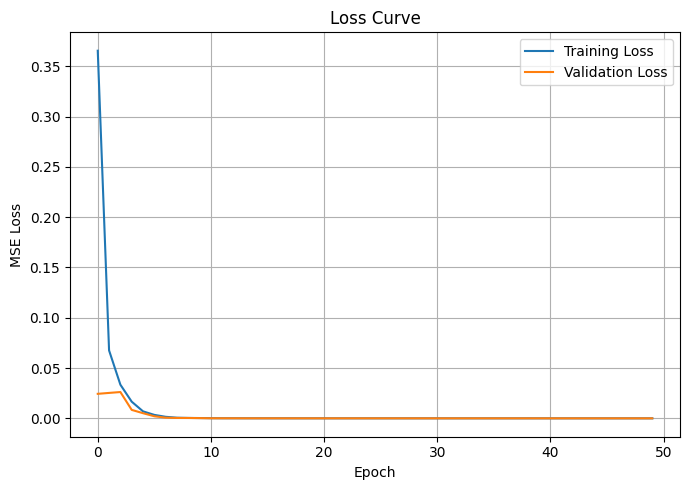

In [19]:
import matplotlib.pyplot as plt

#  Loss curve
plt.figure(figsize=(7,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


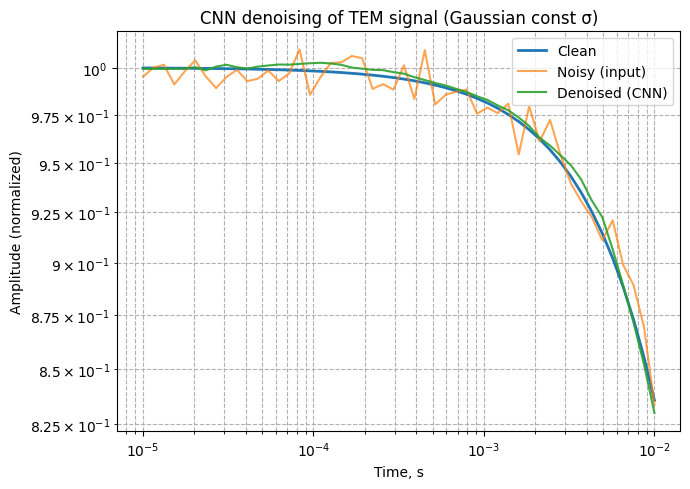

In [36]:
import matplotlib.pyplot as plt


idx = 0
x_test = X_noisy[idx:idx+1]         # shape (1, T, 1)
y_true = Y_clean[idx].squeeze()     # clean
y_noisy = X_noisy[idx].squeeze()    # noisy
y_pred = model.predict(x_test)[0].squeeze()  # denoised

t = times[idx]

plt.figure(figsize=(7, 5))
plt.loglog(t, y_true, label="Clean", linewidth=2)
plt.loglog(t, y_noisy, label="Noisy (input)", alpha=0.7)
plt.loglog(t, y_pred, label="Denoised (CNN)", alpha=0.9)

plt.xlabel("Time, s")
plt.ylabel("Amplitude (normalized)")
plt.title("CNN denoising of TEM signal (Gaussian const σ)")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()


In [33]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X_noisy, Y_clean):

    # Predict value
    preds = model.predict(X_noisy)
    preds = preds.reshape(len(preds), -1)
    Y = Y_clean.reshape(len(Y_clean), -1)


    # MSE(mean squared Error)
    mse = mean_squared_error(Y.flatten(), preds.flatten())

    # RMS(sqrt mean squared Error)
    rmse = np.sqrt(mse)

    # MAE(mean absolute error)
    mae = mean_absolute_error(Y.flatten(), preds.flatten())

    # R²(Coefficient of Determination)
    r2 = r2_score(Y.flatten(), preds.flatten())

    # Print
    print("CNN for Time Domain Electro Magnrtic Model Evaluation ")
    print(f"MSE  (Mean Squared Error):       {mse:.8f}")
    print(f"RMSE (Root MSE):                 {rmse:.8f}")
    print(f"MAE  (Mean Absolute Error):      {mae:.8f}")
    print(f"R²   (Coefficient of Determination): {r2:.6f}")

    return mse, rmse, mae, r2



In [34]:
mse, rmse, mae, r2 = evaluate_model(model, X_noisy, Y_clean)



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
CNN for Time Domain Electro Magnrtic Model Evaluation 
MSE  (Mean Squared Error):       0.00004323
RMSE (Root MSE):                 0.00657497
MAE  (Mean Absolute Error):      0.00397901
R²   (Coefficient of Determination): 0.986411
